In [174]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import random
from tensorflow.compiler.tf2xla.python import xla

## Load the dataset and visualize the data

We use the `keras.datasets.mnist.load_data()` utility to directly pull the MNIST dataset
in the form of `NumPy` arrays. We then arrange it in the form of the train and test
splits.

Following loading the dataset, we select 4 random samples from within the training set
and visualize them using `matplotlib.pyplot`.

4 Random Training samples and labels


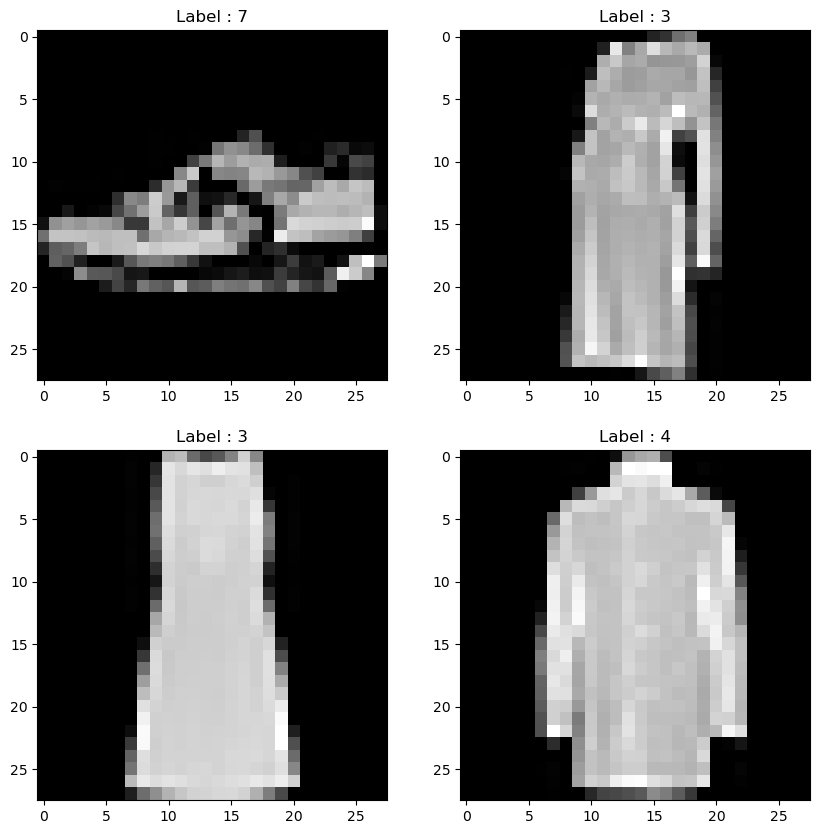

In [175]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

print("4 Random Training samples and labels")
idx1, idx2, idx3, idx4 = random.sample(range(0, x_train.shape[0]), 4)

img1 = (x_train[idx1], y_train[idx1])
img2 = (x_train[idx2], y_train[idx2])
img3 = (x_train[idx3], y_train[idx3])
img4 = (x_train[idx4], y_train[idx4])

imgs = [img1, img2, img3, img4]

plt.figure(figsize=(10, 10))

for idx, item in enumerate(imgs):
    image, label = item[0], item[1]
    plt.subplot(2, 2, idx + 1)
    plt.imshow(image, cmap="gray")
    plt.title(f"Label : {label}")
plt.show()

In [176]:

class FFDense(keras.layers.Layer):
    """
    A custom ForwardForward-enabled Dense layer. It has an implementation of the
    Forward-Forward network internally for use.
    This layer must be used in conjunction with the `FFNetwork` model.
    """

    def __init__(
        self,
        units,
        optimizer,
        loss_metric,
        num_epochs=60,
        use_bias=True,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        kernel_regularizer=None,
        bias_regularizer=None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.dense = keras.layers.Dense(
            units=units,
            use_bias=use_bias,
            kernel_initializer=kernel_initializer,
            bias_initializer=bias_initializer,
            kernel_regularizer=kernel_regularizer,
            bias_regularizer=bias_regularizer,
        )
        self.relu = keras.layers.ReLU()
        self.optimizer = optimizer
        self.loss_metric = loss_metric
        self.threshold = 1.5
        self.num_epochs = num_epochs

    # We perform a normalization step before we run the input through the Dense
    # layer.

    def call(self, x):
        x_norm = tf.norm(x, ord=2, axis=1, keepdims=True)
        x_norm = x_norm + 1e-4
        x_dir = x / x_norm
        res = self.dense(x_dir)
        return self.relu(res)

    # The Forward-Forward algorithm is below. We first perform the Dense-layer
    # operation and then get a Mean Square value for all positive and negative
    # samples respectively.
    # The custom loss function finds the distance between the Mean-squared
    # result and the threshold value we set (a hyperparameter) that will define
    # whether the prediction is positive or negative in nature. Once the loss is
    # calculated, we get a mean across the entire batch combined and perform a
    # gradient calculation and optimization step. This does not technically
    # qualify as backpropagation since there is no gradient being
    # sent to any previous layer and is completely local in nature.

    def forward_forward(self, x_pos, x_neg):
        for i in range(self.num_epochs):
            with tf.GradientTape() as tape:
                g_pos = tf.math.reduce_mean(tf.math.pow(self.call(x_pos), 2), 1)
                g_neg = tf.math.reduce_mean(tf.math.pow(self.call(x_neg), 2), 1)

                loss = tf.math.log(
                    1
                    + tf.math.exp(
                        tf.concat([-g_pos + self.threshold, g_neg - self.threshold], 0)
                    )
                )
                mean_loss = tf.cast(tf.math.reduce_mean(loss), tf.float32)
                self.loss_metric.update_state([mean_loss])
            gradients = tape.gradient(mean_loss, self.dense.trainable_weights)
            self.optimizer.apply_gradients(zip(gradients, self.dense.trainable_weights))
        return (
            tf.stop_gradient(self.call(x_pos)),
            tf.stop_gradient(self.call(x_neg)),
            self.loss_metric.result(),
        )

## Define the `FFNetwork` Custom Model

With our custom layer defined, we also need to override the `train_step` method and
define a custom `keras.models.Model` that works with our `FFDense` layer.

For this algorithm, we must 'embed' the labels onto the original image. To do so, we
exploit the structure of MNIST images where the top-left 10 pixels are always zeros. We
use that as a label space in order to visually one-hot-encode the labels within the image
itself. This action is performed by the `overlay_y_on_x` function.

We break down the prediction function with a per-sample prediction function which is then
called over the entire test set by the overriden `predict()` function. The prediction is
performed here with the help of measuring the `excitation` of the neurons per layer for
each image. This is then summed over all layers to calculate a network-wide 'goodness
score'. The label with the highest 'goodness score' is then chosen as the sample
prediction.

The `train_step` function is overriden to act as the main controlling loop for running
training on each layer as per the number of epochs per layer.

## Convert MNIST `NumPy` arrays to `tf.data.Dataset`

We now perform some preliminary processing on the `NumPy` arrays and then convert them
into the `tf.data.Dataset` format which allows for optimized loading.

In [177]:
x_train = x_train.astype(float) / 255
x_test = x_test.astype(float) / 255
y_train = y_train.astype(int)
y_test = y_test.astype(int)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

train_dataset = train_dataset.batch(60000)
test_dataset = test_dataset.batch(10000)

In [178]:
# find the dimensions of our images
img_width, img_height = x_train.shape[1], x_train.shape[2]
print(f"Image dimensions are {img_width} x {img_height}")

Image dimensions are 28 x 28


## Fit the network and visualize results

Having performed all previous set-up, we are now going to run `model.fit()` and run 250
model epochs, which will perform 50*250 epochs on each layer. We get to see the plotted loss
curve as each layer is trained.

In [179]:
def custom_loss(y_true, y_pred):
    return K.mean(K.square(y_pred-y_true)/K.clip(K.square(0.01*y_pred), K.epsilon(), None), axis=-1)

In [180]:

class FFconv(keras.layers.Layer):
    """
    A custom ForwardForward-enabled convolutional layer.

    """

    def __init__(
        self,
        num_filters,
        optimizer,
        loss_metric,
        num_epochs=60,
        use_bias=True,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        kernel_regularizer=None,
        kernel_size=(3, 3),
        bias_regularizer=None,
        **kwargs,
    ):
        super().__init__(**kwargs)
       
        self.relu = keras.layers.ReLU()
        self.optimizer = optimizer
        self.loss_metric = loss_metric
        self.threshold = 1.5
        self.num_epochs = num_epochs

        # we do the same for the convolutional layer

        self.conv = keras.layers.Conv2D(
            filters=num_filters,
            kernel_size=kernel_size,
            strides=(1, 1),
            padding="same",
            activation="relu",
            kernel_initializer="he_normal",
            bias_initializer="zeros",
        )



    # We perform a normalization step before we run the input through the Dense
    # layer.

    def call(self, x): # we adapt to use on the convolutional layer
    
        x = self.conv(x)
        #print(x.shape)
        x_norm = tf.norm(x, ord=2, axis=1, keepdims=True)
        x_norm = x_norm + 1e-4
        x_dir = x / x_norm
        res = self.relu(x_dir)
        #print(res.shape)
        return res

    # The Forward-Forward algorithm is below. We first perform the Dense-layer
    # operation and then get a Mean Square value for all positive and negative
    # samples respectively.
    # The custom loss function finds the distance between the Mean-squared
    # result and the threshold value we set (a hyperparameter) that will define
    # whether the prediction is positive or negative in nature. Once the loss is
    # calculated, we get a mean across the entire batch combined and perform a
    # gradient calculation and optimization step. This does not technically
    # qualify as backpropagation since there is no gradient being
    # sent to any previous layer and is completely local in nature.

    def forward_forward(self, x_pos, x_neg): # adapt to use on the convolutional layer, first the x_pos and x_neg need to be reshaped
        # we flatten the input
        #x_pos = tf.reshape(x_pos, [-1, tf.shape(x_pos)[1] * tf.shape(x_pos)[2]])
        #x_neg = tf.reshape(x_neg, [-1, tf.shape(x_neg)[1] * tf.shape(x_neg)[2]])
        for i in range(self.num_epochs):
            with tf.GradientTape() as tape:
                # g_pos must be calculated for each image, and is the sum of the squared values of the output of the x_pos vector
                # g_neg must be calculated for each image, and is the sum of the squared values of the output of the x_neg vector
                g_pos = tf.math.reduce_sum(tf.math.square(self.call(x_pos)), 1)
                g_neg = tf.math.reduce_sum(tf.math.square(self.call(x_neg)), 1)
                #print("g_pos",g_pos)
                loss = tf.math.log(
                    1
                    + tf.math.exp(
                        tf.concat([-g_pos + self.threshold, g_neg - self.threshold], 0)
                    )
                )
                mean_loss = tf.cast(tf.math.reduce_mean(loss), tf.float32)
                self.loss_metric.update_state([mean_loss])
            gradients = tape.gradient(mean_loss, self.dense.trainable_weights)
            self.optimizer.apply_gradients(zip(gradients, self.dense.trainable_weights))
        return (
            tf.stop_gradient(self.call(x_pos)),
            tf.stop_gradient(self.call(x_neg)),
            self.loss_metric.result(),
        )


In [181]:
class FFConvModel(keras.Model):
    """
    A custom ForwardForward-enabled convolutional model.

    """

    def __init__(self,dims,loss_metric,optimizer,layer_optimizer=keras.optimizers.legacy.Adam(learning_rate=0.03),num_filters=32,**kwargs):

        super().__init__(**kwargs)
        self.layer_optimizer = layer_optimizer
        self.loss_var = tf.Variable(0.0, trainable=False, dtype=tf.float32)
        self.loss_count = tf.Variable(0.0, trainable=False, dtype=tf.float32)
        self.layer_list = []
        self.layer_list.append(
            FFconv(
                num_filters=num_filters,
                kernel_size=(3, 3),
                optimizer=optimizer,
                loss_metric=loss_metric,
                num_epochs=60,
                name="FFconv_1",
            )
        )
        # we add the flatten layer 
        self.layer_list.append(keras.layers.Flatten())
        self.layer_list.append(FFDense(units=10, optimizer=optimizer, loss_metric=loss_metric, num_epochs=60, name="FFdense_1"))


    # This function makes a dynamic change to the image wherein the labels are
    # put on top of the original image (for this example, as MNIST has 10
    # unique labels, we take the top-left corner's first 10 pixels). This
    # function returns the original data tensor with the first 10 pixels being
    # a pixel-based one-hot representation of the labels.

    @tf.function(reduce_retracing=True)
    def overlay_y_on_x(self, data):
        X_sample, y_sample = data
        max_sample = tf.reduce_max(X_sample, axis=0, keepdims=True)
        max_sample = tf.cast(max_sample, dtype=tf.float64)
        X_zeros = tf.zeros([10], dtype=tf.float64)
        X_update = xla.dynamic_update_slice(X_zeros, max_sample, [y_sample])
        X_sample = xla.dynamic_update_slice(X_sample, X_update, [0])
        return X_sample, y_sample

    # A custom `predict_one_sample` performs predictions by passing the images
    # through the network, measures the results produced by each layer (i.e.
    # how high/low the output values are with respect to the set threshold for
    # each label) and then simply finding the label with the highest values.
    # In such a case, the images are tested for their 'goodness' with all
    # labels.

    @tf.function(reduce_retracing=True)
    def predict_one_sample(self, x):
        goodness_per_label = []
        #x = tf.reshape(x, [tf.shape(x)[0] * tf.shape(x)[1]])
        for label in range(10):
            h, label = self.overlay_y_on_x(data=(x, label))
            h = tf.reshape(h, [-1, tf.shape(h)[0]])
            goodness = []
            for layer_idx in range(1, len(self.layer_list)):
                layer = self.layer_list[layer_idx]
                h = layer(h)
                
                goodness += [tf.math.reduce_mean(tf.math.pow(h, 2), 1)]
            goodness_per_label += [
                tf.expand_dims(tf.reduce_sum(goodness, keepdims=True), 1)
            ]
        goodness_per_label = tf.concat(goodness_per_label, 1)
        return tf.cast(tf.argmax(goodness_per_label, 1), tf.float64)

    def predict(self, data):
        x = data
        preds = list()
        preds = tf.map_fn(fn=self.predict_one_sample, elems=x)
        return np.asarray(preds, dtype=int)

    # This custom `train_step` function overrides the internal `train_step`
    # implementation. We take all the input image tensors, flatten them and
    # subsequently produce positive and negative samples on the images.
    # A positive sample is an image that has the right label encoded on it with
    # the `overlay_y_on_x` function. A negative sample is an image that has an
    # erroneous label present on it.
    # With the samples ready, we pass them through each `FFLayer` and perform
    # the Forward-Forward computation on it. The returned loss is the final
    # loss value over all the layers.

    @tf.function(jit_compile=True)
    def train_step(self, data):
        x, y = data
        # we store the shape of the input tensor to reshape the output
        input_shape = tf.shape(x)

        # Flatten op
        x = tf.reshape(x, [-1, tf.shape(x)[1] * tf.shape(x)[2]])
        # convert to float64
        x = tf.cast(x, dtype=tf.float64)
        x_pos, y = tf.map_fn(fn=self.overlay_y_on_x, elems=(x, y))
        random_y = tf.random.shuffle(y)
        x_neg, y = tf.map_fn(fn=self.overlay_y_on_x, elems=(x, random_y))
        
        h_pos, h_neg = x_pos, x_neg

        for idx, layer in enumerate(self.layer_list):
            if isinstance(layer, FFDense):
                print(f"Training layer {idx+1} now : ")
                
                h_pos, h_neg, loss = layer.forward_forward(h_pos, h_neg)
                self.loss_var.assign_add(loss)
                self.loss_count.assign_add(1.0)
            if isinstance(layer, FFconv):
                print(f"Training layer {idx+1} now : ")
                h_neg = tf.reshape(h_neg, [input_shape[0],input_shape[1],input_shape[2],1])
                h_pos = tf.reshape(h_pos, [input_shape[0],input_shape[1],input_shape[2],1])
                h_pos, h_neg, loss = layer.forward_forward(h_pos, h_neg)
                self.loss_var.assign_add(loss)
                self.loss_count.assign_add(1.0)
            else:
                print(f"Passing layer {idx+1} now : ")
                x = layer(x)
        mean_res = tf.math.divide(self.loss_var, self.loss_count)
        return {"FinalLoss": mean_res}
    
    



In [182]:
# create the model

loss_metric = keras.metrics.Mean(name="loss")
optimizer = keras.optimizers.Adam(learning_rate=0.001)

model = FFConvModel(dims=[784],loss_metric=loss_metric,optimizer=optimizer)

# compile the model
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [183]:
print(x_train.shape)

(60000, 28, 28)


In [184]:
# train the model
model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.1)

Epoch 1/10
Training layer 1 now : 


AttributeError: in user code:

    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/tmp/ipykernel_27/2080321620.py", line 114, in train_step  *
        h_pos, h_neg, loss = layer.forward_forward(h_pos, h_neg)
    File "/tmp/ipykernel_27/1949813855.py", line 87, in forward_forward  *
        gradients = tape.gradient(mean_loss, self.dense.trainable_weights)

    AttributeError: 'FFconv' object has no attribute 'dense'
